# Eksperimen Machine Learning - Taxi Trip Data
**Nama:** Anwar Muslim

**Dataset:** Taxi Trip Data (Green Taxi)

Notebook ini bertujuan untuk melakukan eksplorasi data (EDA), pembersihan data (Preprocessing), dan eksperimen model awal sebelum proses ini diotomatisasi.

**Tujuan Eksperimen:**
1. Memahami karakteristik data.
2. Menentukan fitur yang relevan (Feature Selection).
3. Membersihkan data dari noise dan missing values.
4. Membuat baseline model.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Konfigurasi plot
sns.set(style="whitegrid")
%matplotlib inline

## Load Data

In [9]:
# Load dataset
df = pd.read_csv('../taxi_tripdata_raw/taxi_tripdata_raw.csv')
# Tampilkan 5 baris teratas
df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_16600\3447802644.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../taxi_tripdata_raw/taxi_tripdata_raw.csv')


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,1.0,2021-07-01 00:30:52,2021-07-01 00:35:36,N,1.0,74,168,1.0,1.20,6.0,0.5,0.5,0.00,0.0,NaN,0.3,7.30,2.0,1.0,0.0
1,2.0,2021-07-01 00:25:36,2021-07-01 01:01:31,N,1.0,116,265,2.0,13.69,42.0,0.5,0.5,0.00,0.0,NaN,0.3,43.30,2.0,1.0,0.0
2,2.0,2021-07-01 00:05:58,2021-07-01 00:12:00,N,1.0,97,33,1.0,0.95,6.5,0.5,0.5,2.34,0.0,NaN,0.3,10.14,1.0,1.0,0.0
3,2.0,2021-07-01 00:41:40,2021-07-01 00:47:23,N,1.0,74,42,1.0,1.24,6.5,0.5,0.5,0.00,0.0,NaN,0.3,7.80,2.0,1.0,0.0
4,2.0,2021-07-01 00:51:32,2021-07-01 00:58:46,N,1.0,42,244,1.0,1.10,7.0,0.5,0.5,0.00,0.0,NaN,0.3,8.30,2.0,1.0,0.0


## Info Awal Data

In [10]:
# Cek tipe data dan missing values
df.info()

print("\nJumlah Missing Values per Kolom:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83691 entries, 0 to 83690
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               51173 non-null  float64
 1   lpep_pickup_datetime   83691 non-null  object 
 2   lpep_dropoff_datetime  83691 non-null  object 
 3   store_and_fwd_flag     51173 non-null  object 
 4   RatecodeID             51173 non-null  float64
 5   PULocationID           83691 non-null  int64  
 6   DOLocationID           83691 non-null  int64  
 7   passenger_count        51173 non-null  float64
 8   trip_distance          83691 non-null  float64
 9   fare_amount            83691 non-null  float64
 10  extra                  83691 non-null  float64
 11  mta_tax                83691 non-null  float64
 12  tip_amount             83691 non-null  float64
 13  tolls_amount           83691 non-null  float64
 14  ehail_fee              0 non-null      float64
 15  im

## Data Cleaning dan Feature Selection

In [11]:
# --- STEP 1: Feature Engineering (Durasi) ---
# Kita hitung durasi dulu sebelum seleksi fitur
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

# Hitung durasi dalam menit
df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60

# --- STEP 2: Seleksi Fitur ---
# Sekarang kita masukkan 'trip_duration' ke fitur
target_col = 'fare_amount'
# Menambahkan trip_duration agar hasil prediksi akurat
feature_cols = ['passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'trip_duration']

relevant_cols = feature_cols + [target_col]
df_clean = df[relevant_cols].copy()

# --- STEP 3: Cleaning ---
df_clean = df_clean.dropna()
# Filter: Harga, Jarak, dan Durasi harus positif
df_clean = df_clean[ (df_clean['fare_amount'] > 0) & (df_clean['trip_distance'] > 0) & (df_clean['trip_duration'] > 0) ]

# Filter Outlier Durasi (Contoh: Hapus perjalanan > 3 jam agar tidak bias)
df_clean = df_clean[ df_clean['trip_duration'] <= 180 ]

if 'passenger_count' in df_clean.columns:
    df_clean = df_clean[(df_clean['passenger_count'] > 0) & (df_clean['passenger_count'] <= 6)]

print(f"Data Cleaned: {df_clean.shape}")
df_clean.head()

Data Cleaned: (47774, 6)


,passenger_count,trip_distance,PULocationID,DOLocationID,trip_duration,fare_amount
0,1.0,1.20,74,168,4.733333,6.0
1,2.0,13.69,116,265,35.916667,42.0
2,1.0,0.95,97,33,6.033333,6.5
3,1.0,1.24,74,42,5.716667,6.5
4,1.0,1.10,42,244,7.233333,7.0


## Visualisasi

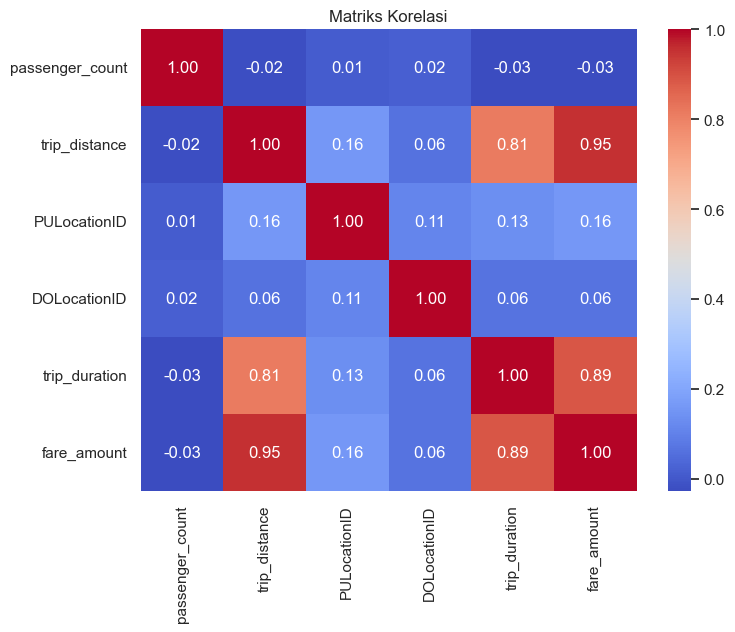

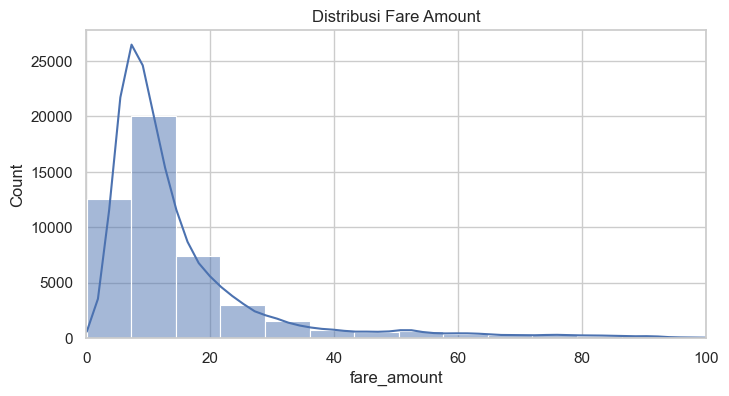

In [12]:
# Melihat korelasi antar fitur
plt.figure(figsize=(8, 6))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriks Korelasi')
plt.show()

# Distribusi Target
plt.figure(figsize=(8, 4))
sns.histplot(df_clean['fare_amount'], bins=50, kde=True)
plt.title('Distribusi Fare Amount')
plt.xlim(0, 100) # Membatasi view agar outlier ekstrem tidak merusak grafik
plt.show()

## Splitting

In [13]:
# Definisi X dan y
X = df_clean[feature_cols]
y = df_clean[target_col]

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data berhasil di-split.")
print(f"Jumlah Train: {len(X_train)}")
print(f"Jumlah Test : {len(X_test)}")

Data berhasil di-split.
Jumlah Train: 38219
Jumlah Test : 9555


## Modelling

In [14]:
# Kita coba model Random Forest sederhana
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)

print("Sedang melatih model...")
rf_model.fit(X_train, y_train)

# Prediksi
y_pred = rf_model.predict(X_test)

# Evaluasi
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

Sedang melatih model...
RMSE: 3.298931961055057
R2 Score: 0.9473093775523036
